**References:**

- [github/karpathy/makemore](https://github.com/karpathy/makemore)
- [github/karpathy/nn-zero-to-hero](https://github.com/karpathy/nn-zero-to-hero/blob/master/lectures/makemore/makemore_part2_mlp.ipynb)
- [paper](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('data/names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [4]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      # print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [5]:
num_chs = 27
dim_emb = 2
dim_hid = 100
C = torch.randn((num_chs, dim_emb)) # lookup table
W1 = torch.randn((block_size * dim_emb, dim_hid)) # hidden layer weights
b1 = torch.randn(dim_hid) # hidden layer biases
W2 = torch.randn((dim_hid, num_chs)) # output layer weights
b2 = torch.randn(num_chs) # output layer biases
parameters = [C, W1, b1, W2, b2]
print("total number of parameters:", sum(p.nelement() for p in parameters))

total number of parameters: 3481


In [6]:
for p in parameters:
  p.requires_grad = True

In [7]:
lossi = []
BS = 32

In [8]:
for i in range(20000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], size=(BS,))
  
  # forward pass
  emb = C[Xtr[ix]] # (BS, block_size, dim_emb) (32, 3, 2)
  h = torch.tanh(emb.view(-1, block_size * dim_emb) @ W1 + b1) # (BS, dim_hid) (32, 100)
  logits = h @ W2 + b2 # (BS, num_chs) (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  if i % 1000 == 0: print(f"loss at step {i}: {loss.item()}")
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # lr decay lol
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  lossi.append(loss.log10().item())

loss at step 0: 18.17816734313965
loss at step 1000: 2.114788770675659
loss at step 2000: 2.833698034286499
loss at step 3000: 2.8691139221191406
loss at step 4000: 2.3577542304992676
loss at step 5000: 2.305111885070801
loss at step 6000: 2.185377836227417
loss at step 7000: 3.176168441772461
loss at step 8000: 2.437314033508301
loss at step 9000: 2.6896064281463623
loss at step 10000: 2.469217538833618
loss at step 11000: 2.5263614654541016
loss at step 12000: 2.430050849914551
loss at step 13000: 2.20076584815979
loss at step 14000: 2.427978277206421
loss at step 15000: 2.523467779159546
loss at step 16000: 2.7824625968933105
loss at step 17000: 1.9264509677886963
loss at step 18000: 2.6216909885406494
loss at step 19000: 2.3174033164978027


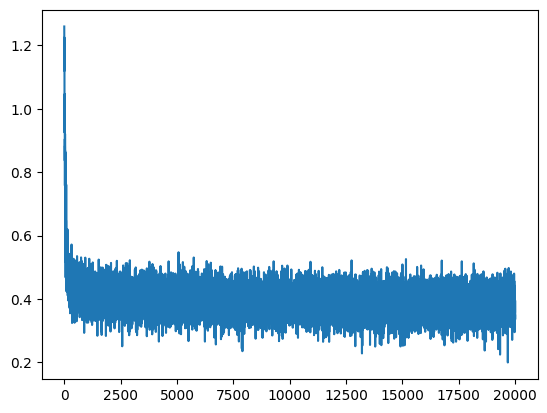

In [9]:
plt.plot(lossi)

In [10]:
# test with dev set
emb = C[Xdev] # (22655, block_size, dim_emb) (22655, 3, 2)
h = torch.tanh(emb.view(-1, block_size * dim_emb) @ W1 + b1) # (22655, dim_hid) (22655, 100)
logits = h @ W2 + b2 # (22655, num_chs) (22655, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.4236, grad_fn=<NllLossBackward0>)

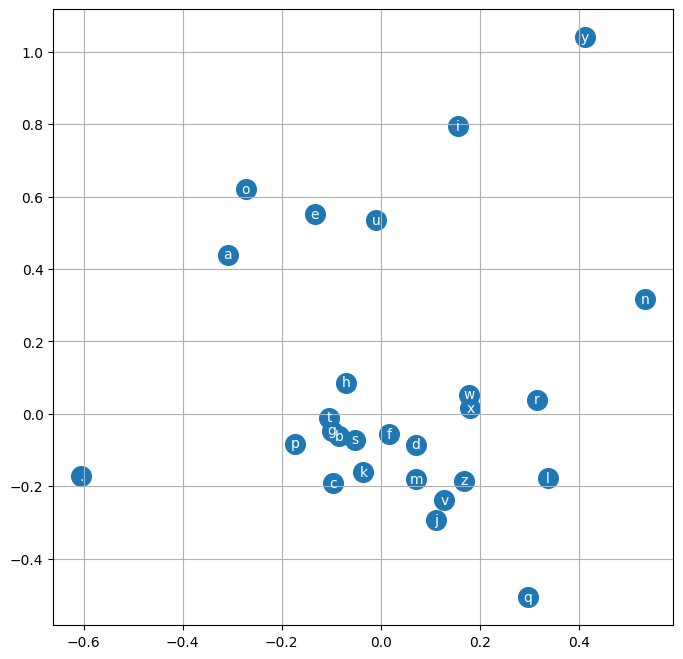

In [11]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [12]:
# sample from the model
for _ in range(20):
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

enora.
carira.
dholvinzlynna.
almlajadben.
kaqaan.
keren.
kana.
whh.
omaylan.
mava.
namahgijeilee.
rri.
moryna.
mayananabanelis.
harcadir.
kan.
lom.
dina.
carny.
zh.
